# Deep Learning Question & Answer Bot Project

## Project Overview
In this project, we implement a chatbot that can answer questions based on a "story" given to the bot.

We are using a subset of the BaBi dataset released by Facebook research. https://research.fb.com/downloads/babi.
There are 10,000 data in the training set and 1,000 data in the testing set. Each data in the training/testing set consists of 3 components:
> - Story - consists of single or multiple sentences
> - Question - single sentence query related to the story
> - Answer - "yes" or "no" answer to the question

The model for our chatbot is a RNN network with attention mechanism. It includes the following layers: Embedding, LSTM, Dropout, Dense and Activation. The design of the model pretty much follows the idea in the paper "End-to-End Memory Networks": https://arxiv.org/pdf/1503.08895.pdf. 

Our model achieved pretty high accuary on training/testing set and performs really good on run time generated data.

## Data Preprocessing

In [1]:
import pickle
import numpy as np

In [2]:
# Read as binary
with open('train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
# Read as binary
with open('test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
print(type(train_data))
print(type(test_data))

<class 'list'>
<class 'list'>


In [5]:
print("Length of the train data: ", len(train_data))
print("Length of the test data: ", len(test_data))

Length of the train data:  10000
Length of the test data:  1000


In [6]:
train_data[:2]

[(['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
  'no'),
 (['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'went',
   'back',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.'],
  ['Is', 'Daniel', 'in', 'the', 'bathroom', '?'],
  'no')]

In [7]:
# Train_data is a list of tuples consist of 3 parts: story, question, answer.
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [8]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [9]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [10]:
train_data[0][2]

'no'

In [11]:
all_data = test_data + train_data

In [12]:
len(all_data)

11000

In [13]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [14]:
# Build vocabulary from all stories and questions
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [15]:
vocab.add('no')

In [16]:
vocab.add('yes')

In [17]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [18]:
# Add one to length of vocabulary: Keras embedding layer requires this.
vocab_len = len(vocab) + 1
print("Actual length of the vocabulary: ", vocab_len-1)

Actual length of the vocabulary:  37


In [19]:
# Length of all the stories
all_story_len = [len(data[0]) for data in all_data]

In [20]:
# Get maximum of the stories
max_story_len = max(all_story_len)

In [21]:
max_question_len = max([len(data[1]) for data in all_data])

In [22]:
print("Maximum length of the stories: ", max_story_len)
print("Maximum length of the question: ", max_question_len)

Maximum length of the stories:  156
Maximum length of the question:  6


In [23]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [24]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [25]:
tokenizer.word_index

{'back': 1,
 'down': 2,
 '.': 3,
 'daniel': 4,
 'got': 5,
 'the': 6,
 'in': 7,
 'put': 8,
 'hallway': 9,
 'apple': 10,
 '?': 11,
 'office': 12,
 'went': 13,
 'yes': 14,
 'left': 15,
 'up': 16,
 'john': 17,
 'journeyed': 18,
 'moved': 19,
 'milk': 20,
 'is': 21,
 'garden': 22,
 'picked': 23,
 'there': 24,
 'took': 25,
 'football': 26,
 'dropped': 27,
 'mary': 28,
 'sandra': 29,
 'bathroom': 30,
 'bedroom': 31,
 'travelled': 32,
 'kitchen': 33,
 'discarded': 34,
 'to': 35,
 'grabbed': 36,
 'no': 37}

In [26]:
train_story_text = []
train_question_text = []
train_answers = []

In [27]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [28]:
# Train_story_text is a list of lists of words
train_story_text[:2]

[['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.',
  'Mary',
  'went',
  'back',
  'to',
  'the',
  'bedroom',
  '.',
  'Daniel',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.']]

In [29]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [30]:
print(len(train_story_seq))
print(len(train_story_text))

10000
10000


In [31]:
train_story_text[:2]

[['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.',
  'Mary',
  'went',
  'back',
  'to',
  'the',
  'bedroom',
  '.',
  'Daniel',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.']]

In [32]:
train_story_seq[:2]

[[28, 19, 35, 6, 30, 3, 29, 18, 35, 6, 31, 3],
 [28,
  19,
  35,
  6,
  30,
  3,
  29,
  18,
  35,
  6,
  31,
  3,
  28,
  13,
  1,
  35,
  6,
  31,
  3,
  4,
  13,
  1,
  35,
  6,
  9,
  3]]

In [33]:
# Create our own list of list of word indicies with padding.
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len):
    # Stories = X
    X = []
    
    # Questions = Xq
    Xq = []
    
    # Y Correct Answer ['yes', 'no']
    Y = []
    for story, query, answer in data:
        
        # for each story
        # [23, 14, 15]
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        
        X.append(x)   # X holds list of lists of word indices for stories.
        Xq.append(xq) # Xq holds list of lists for word indices for questions.
        Y.append(y) # Y holds lists of lists of (38) biniary numbers, only 1 of them is 1.
        
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [34]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [35]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [36]:
inputs_test

array([[ 0,  0,  0, ..., 30,  5, 31],
       [ 0,  0,  0, ..., 30, 32, 31],
       [ 0,  0,  0, ..., 30, 32, 31],
       ...,
       [ 0,  0,  0, ..., 30, 23, 31],
       [ 0,  0,  0, ..., 30, 32, 31],
       [ 0,  0,  0, ..., 23, 26, 31]])

In [37]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
tokenizer.word_index['yes']

15

In [39]:
tokenizer.word_index['no']

24

In [40]:
# 497 of the questions have answer 'yes', 503 of the questions have answer 'no'.
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [41]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

## Algorithms and Techniques

The design in this project follows the paper "End-to-End Memory Networks" https://arxiv.org/pdf/1503.08895.pdf

Below are the detail descriptions about the algorithms and techniques used in this model (quoted from that paper):

**Single Layer:**
<img src="images/end_to_end_networks_descriptions.GIF" style="width:500;height:500px;">

<img src="images/end_to_end_networks_diagram3.GIF" style="width:500;height:500px;">

Source of the above figure: https://arxiv.org/pdf/1503.08895.pdf

## Architecture of the model

The architecture of the model implemented below follows the paper: The https://arxiv.org/pdf/1503.08895.pdf

The layers of the model looks like:
1. Input
> - A. input_sequence (fits on input_train): shape = (batch_size, max_story_len))
> - B. question (fits on queries_train: shape = (batch_size, max_query_len))
2. Embedding
> - A. embedding for input_encoder_m: take input from input_sequence. Output shape: (batch_size, story_maxlen, embedding_dim)
> - B. embedding for input_encoder_c: take input from input_sequence. Output shape: (batch_size, story_maxlen, max_question_len)
> - C. embedding for question_encoder: take input from question. Output shape: (batch_size, query_maxlen, embedding_dim)
3. Layers after Embedding
> - A. dot: dot input_encoded_m and question_encoded (output from 2A and 2C) along axes of embedding dimension. Output shape: (batch_size, story_maxlen, query_maxlen)
> - B. add: add output from 3A and 2B. Output shape: (batch_size, story_maxlen, query_maxlen)
> - C. Permute: permute 2nd and 3rd axes from output of 3B. Output shape: (batch_size, query_maxlen, story_maxlen)
> - D. concatenate: concatenate output from 3C and 2B. Output shape: (batch_size, query_maxlen, story_maxlen+embedding_dim) 
4. LSTM (hidden_unit = 32)
5. Dropout (rate = 0.3)
6. Dense (output = vocab_size)
7. Activation (activation function = 'softmax')

In [42]:
# PLACEHOLDER shape=(max_story_len, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [43]:
# vocab_len
vocab_size = len(vocab) + 1

In [44]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

# OUTPUT
# (samples, story_maxlen, embedding_dim)

In [45]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# OUTPUT
# (samples, story_maxlen, max_question_len)

In [46]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

# OUTPUT
# (samples, query_maxlen, embedding_dim)

In [47]:
# ENCODED <---- ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# input_encoded_m: (batch_size, story_maxlen, embedding_dim)
# input_encoded_c: (batch_size, story_maxlen, query_maxlen)
# question_encoded: (batch_size, query_maxlen, embedding_dim)

In [48]:
print(input_encoded_m.shape)
print(question_encoded.shape)

(?, 156, 64)
(?, 6, 64)


In [49]:
match = dot([input_encoded_m, question_encoded], axes=(2,2)) # why axes is (2,2) ==> dot product along the embedding dim (64 numbers dot 64 numbers)
match = Activation('softmax')(match)

# NOTE: match after dot: (batch_size, story_maxlen, query_maxlen)
# match after Activation: (batch_size, story_maxlen, query_maxlen)

**NOTE: match (after dot): (batch_size, story_maxlen, query_maxlen)!!!**

In [50]:
response = add([match, input_encoded_c]) # (samples, story_maxlen, query_maxlen)
response = Permute((2,1))(response) # (samples, query_maxlen, story_maxlen)

# response after add: (batch_size, story_maxlen, query_maxlen)
# response after Permute: (batch_size, query_maxlen, story_maxlen)

**NOTE: response after Permute: (batch_size, query_maxlen, story_maxlen)!!!**

In [51]:
answer = concatenate([response, question_encoded])

# Note: answer: (batch_size, query_maxlen, story_maxlen+embedding_dim)

In [52]:
answer
# Note: answer: (batch_size, query_maxlen, story_maxlen+embedding_dim)

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

**NOTE: answer (after concatenate): (batch_size, query_maxlen, story_maxlen+embedding_dim)!!!**

In [53]:
answer = LSTM(32)(answer) #(samples, 32)
# answer: (batch_size, 32)

In [54]:
print(answer.shape)

(?, 32)


In [55]:
answer = Dropout(0.5)(answer)
# answer: (batch_size, 32)

In [56]:
answer = Dense(vocab_size)(answer) # (samples, vocab_size) # YES/NO 0000
# answer (batch_size, vocab_size)

In [57]:
answer = Activation('softmax')(answer)
# answer: (batch_size, vocab_size)

In [58]:
answer

<tf.Tensor 'activation_2/Softmax:0' shape=(?, 38) dtype=float32>

In [59]:
model = Model([input_sequence, question], answer)

In [60]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [62]:
#history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=100, validation_data=([inputs_test, queries_test], answers_test))
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=100, validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 13s 1ms/step - loss: 1.0238 - acc: 0.4941 - val_loss: 0.7043 - val_acc: 0.4970
Epoch 2/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.7187 - acc: 0.5034 - val_loss: 0.6980 - val_acc: 0.5030
Epoch 3/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.7055 - acc: 0.4947 - val_loss: 0.6958 - val_acc: 0.4970
Epoch 4/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.7004 - acc: 0.4948 - val_loss: 0.6955 - val_acc: 0.4970
Epoch 5/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6988 - acc: 0.4958 - val_loss: 0.6943 - val_acc: 0.4970
Epoch 6/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6977 - acc: 0.5006 - val_loss: 0.6937 - val_acc: 0.5030
Epoch 7/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6961 - acc: 0.5066 - val_loss: 0.6944 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


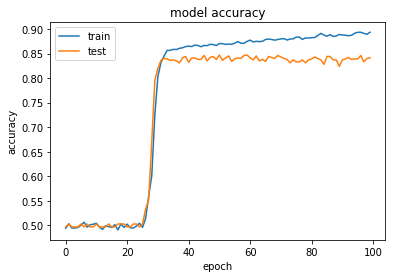

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
model.save('mybrandnewmodel.h5')

In [66]:
pred_result = model.predict(([inputs_test, queries_test]))

In [67]:
pred_result.shape

(1000, 38)

In [68]:
pred_result[0]

array([2.2588785e-15, 2.9219460e-15, 2.4675469e-15, 2.6234957e-15,
       1.8284026e-15, 2.3396153e-15, 3.5231821e-15, 2.2525454e-15,
       1.9747961e-15, 2.5935639e-15, 3.9396256e-15, 2.2929019e-15,
       3.2575407e-15, 3.2082487e-15, 2.8868469e-15, 8.0848877e-06,
       2.7744221e-15, 1.8075077e-15, 4.5423239e-15, 1.4052955e-15,
       2.8729060e-15, 2.7312419e-15, 2.1349381e-15, 3.2994621e-15,
       9.9999189e-01, 3.5153284e-15, 1.7340312e-15, 3.3040468e-15,
       2.3915645e-15, 2.2861070e-15, 2.9147878e-15, 3.4532324e-15,
       2.0619327e-15, 3.3544396e-15, 2.9790081e-15, 3.3928157e-15,
       4.2264882e-15, 2.1006688e-15], dtype=float32)

In [69]:
index_word = {index: word for word, index in tokenizer.word_index.items()}

In [70]:
predictions = np.argmax(pred_result, axis=1)
pred_answers = [index_word[pred] for pred in predictions]
pred_answers

['no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no

## Test with a run time question.

In [71]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."

In [72]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [73]:
my_question = "Is the football in the garden ?"

In [74]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [75]:
# The answer should be 'yes'.
mydata = [(my_story.split(), my_question.split(), 'yes')]

In [76]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [82]:
pred_result = model.predict([my_story, my_ques])

In [83]:
val_max = np.argmax(pred_result[0])

In [88]:
# Get the answer corresponding to the highest predict probabilty.
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [89]:
k

'yes'

In [86]:
# Find out what's the highest predict probability.
pred_result[0][val_max]

0.95445025